In [55]:
import matplotlib.pyplot as plt
from orbit.utils.dataset import load_iclaims
import numpy as np

In [3]:
raw_data = load_iclaims()
raw_data

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404
...,...,...,...,...,...,...,...
438,2018-05-27,12.220202,0.116342,-0.004795,0.052260,0.452972,-0.175192
439,2018-06-03,12.162763,0.134360,0.014254,0.052260,0.469082,-0.275119
440,2018-06-10,12.288984,0.134360,0.104405,0.063433,0.469308,-0.291676
441,2018-06-17,12.235743,0.097992,0.104405,0.029532,0.460354,-0.152422


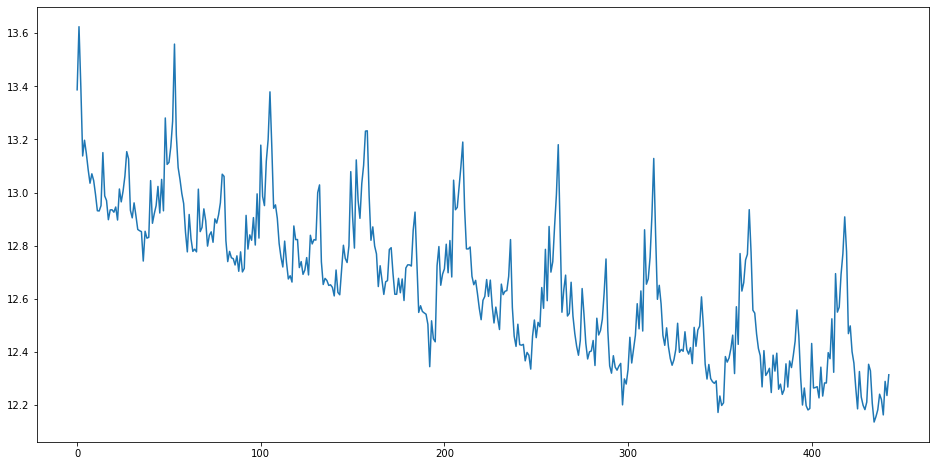

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(raw_data['claims'])

In [272]:
import os

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import set_matplotlib_formats

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.diagnostics import autocorrelation, hpdi
from numpyro.infer import MCMC, NUTS, Predictive, autoguide, SVI, Trace_ELBO

In [279]:
def ets(response, seasonality, seasonality_sd, response_sd):
    n_obs = len(response)
    lev_sm = numpyro.sample("lev_sm", dist.Uniform(0, 1))
    sea_sm = numpyro.sample("sea_sm", dist.Uniform(0, 1))
    obs_sigma = numpyro.sample("obs_sigma", dist.Cauchy(0, response_sd))
    
    with numpyro.plate("seasonality", seasonality - 1):
        init_sea_param = numpyro.sample("init_sea", dist.Normal(0, seasonality_sd))
    init_sea = jnp.hstack(
        (init_sea_param[1:], -1 * jnp.sum(init_sea_param), init_sea_param[0])
    )

    init_lev = response[0] - init_sea_param[0]
    
    def transition_fn(carry, t):
        prev_lev, prev_sea = carry
        # forecast
        yhat = prev_lev + prev_sea[0]
        
        # update
        new_lev = lev_sm * (response[t] - prev_sea[0]) + (1 - lev_sm) * prev_lev
        sea_update = sea_sm * (response[t] - new_lev) + (1 - sea_sm) * prev_sea[0]
        # sea_update = prev_sea[0]
        new_sea = jnp.hstack((prev_sea[1:], sea_update))

        return (new_lev, new_sea), (new_lev, sea_update, yhat)
        

    _, res = scan(
        transition_fn, (init_lev, init_sea), jnp.arange(1, n_obs)
    )
    l_generated, s_generated, yhat_generated = res
    numpyro.sample("response", dist.Normal(yhat_generated, obs_sigma), obs=response[1:])
    
    numpyro.deterministic("s", jnp.hstack((init_sea_param[0], init_sea, s_generated)))
    numpyro.deterministic("l", jnp.hstack((init_lev, l_generated)))
    numpyro.deterministic("yhat", jnp.hstack((response[0], yhat_generated)))

In [280]:
response = jnp.array(raw_data['claims'].values)
response_sd = jnp.std(response)
seasonality_sd = response_sd
seasonality = 52

In [281]:
%%time
kernel = NUTS(ets)
mcmc = MCMC(kernel, num_warmup=3000, num_samples=1000, num_chains=1)
mcmc.run(random.PRNGKey(0), response, seasonality, seasonality_sd, response_sd)
mcmc.print_summary()
samples = mcmc.get_samples()

  0%|                                                                                              | 0/4000 [00:00<?, ?it/s]/Users/towinazure/opt/miniconda3/envs/ts/lib/python3.8/site-packages/numpyro/contrib/control_flow/scan.py:264: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  length = tree_flatten(xs)[0][0].shape[0]
sample: 100%|███████████████████████████████| 4000/4000 [00:04<00:00, 839.06it/s, 31 steps of size 1.44e-01. acc. prob=0.94]
/Users/towinazure/opt/miniconda3/envs/ts/lib/python3.8/site-packages/numpyro/contrib/control_flow/scan.py:264: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  length = tree_flatten(xs)[0][0].shape[0]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
 init_sea[0]      0.33      0.03      0.33      0.29      0.37   1623.63      1.00
 init_sea[1]      0.55      0.05      0.55      0.47      0.64   2021.10      1.00
 init_sea[2]      0.32      0.06      0.32      0.22      0.40   1648.13      1.00
 init_sea[3]      0.08      0.06      0.08     -0.01      0.17   2176.00      1.00
 init_sea[4]      0.11      0.06      0.11      0.03      0.21   1800.96      1.00
 init_sea[5]      0.06      0.05      0.06     -0.03      0.14   2738.09      1.00
 init_sea[6]      0.00      0.06     -0.00     -0.10      0.09   1858.41      1.00
 init_sea[7]     -0.06      0.05     -0.06     -0.14      0.02   1933.51      1.00
 init_sea[8]     -0.04      0.05     -0.04     -0.14      0.04   1900.61      1.00
 init_sea[9]     -0.02      0.06     -0.02     -0.11      0.07   1832.87      1.00
init_sea[10]     -0.08      0.05     -0.08     -0.17      0.01   1970.13      1.00
ini

In [282]:
yhat = np.array(samples['yhat'])
yhat_med, yhat_upper, yhat_lower = np.quantile(yhat, q=[0.5, 0.95, 0.05], axis=0)

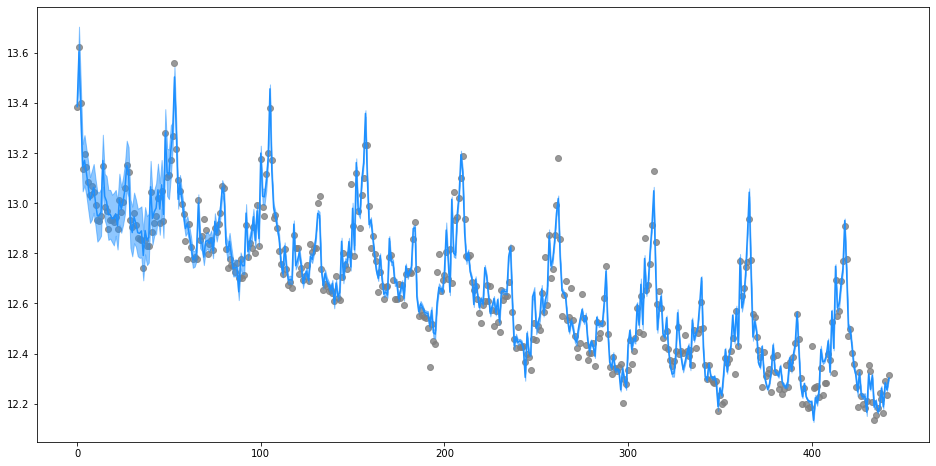

In [283]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
x = np.arange(len(response))
ax.scatter(x, response, color='grey', alpha=0.8)
ax.plot(x, yhat_med, color='dodgerblue')
ax.fill_between(x, yhat_lower, yhat_upper, color='dodgerblue', alpha=0.5)

In [284]:
lev = np.array(samples['l'])
lev_med, lev_upper, lev_lower = np.quantile(lev, q=[0.5, 0.95, 0.05], axis=0)

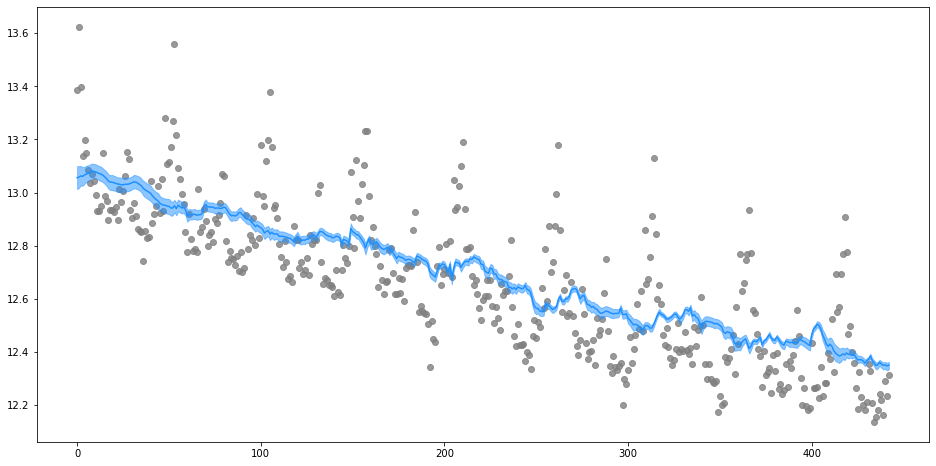

In [285]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
x = np.arange(len(response))
ax.scatter(x, response, color='grey', alpha=0.8)
ax.plot(x, lev_med, color='dodgerblue')
ax.fill_between(x, lev_lower, lev_upper, color='dodgerblue', alpha=0.5)

In [286]:
seas = np.array(samples['s'])
seas_med, seas_upper, seas_lower = np.quantile(seas, q=[0.5, 0.95, 0.05], axis=0)

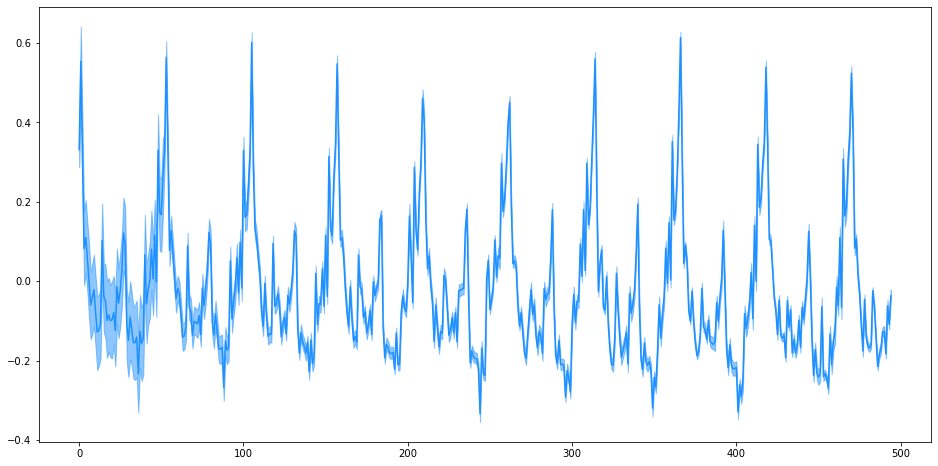

In [287]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
x = np.arange(len(seas_med))
ax.plot(x, seas_med, color='dodgerblue')
ax.fill_between(x, seas_lower, seas_upper, color='dodgerblue', alpha=0.5)

In [288]:
guide = autoguide.AutoDelta(ets)
optimizer = numpyro.optim.Adam(0.001)
svi = SVI(ets, guide, optimizer, Trace_ELBO())
svi_results = svi.run(random.PRNGKey(1), 10000,  response, seasonality, seasonality_sd, response_sd)
params = svi_results.params

/Users/towinazure/opt/miniconda3/envs/ts/lib/python3.8/site-packages/numpyro/contrib/control_flow/scan.py:264: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  length = tree_flatten(xs)[0][0].shape[0]
/Users/towinazure/opt/miniconda3/envs/ts/lib/python3.8/site-packages/numpyro/contrib/control_flow/scan.py:264: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  length = tree_flatten(xs)[0][0].shape[0]
/Users/towinazure/opt/miniconda3/envs/ts/lib/python3.8/site-packages/numpyro/contrib/control_flow/scan.py:264: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  length = tree_flatten(xs)[0][0].shape[0]
100%|██████████████████████| 10000/10000 [00:02<00:00, 3747.00it/s, init loss: -228.8708, avg. loss [9501-10000]: -617.2904]


In [290]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
 init_sea[0]      0.33      0.03      0.33      0.29      0.37   1623.63      1.00
 init_sea[1]      0.55      0.05      0.55      0.47      0.64   2021.10      1.00
 init_sea[2]      0.32      0.06      0.32      0.22      0.40   1648.13      1.00
 init_sea[3]      0.08      0.06      0.08     -0.01      0.17   2176.00      1.00
 init_sea[4]      0.11      0.06      0.11      0.03      0.21   1800.96      1.00
 init_sea[5]      0.06      0.05      0.06     -0.03      0.14   2738.09      1.00
 init_sea[6]      0.00      0.06     -0.00     -0.10      0.09   1858.41      1.00
 init_sea[7]     -0.06      0.05     -0.06     -0.14      0.02   1933.51      1.00
 init_sea[8]     -0.04      0.05     -0.04     -0.14      0.04   1900.61      1.00
 init_sea[9]     -0.02      0.06     -0.02     -0.11      0.07   1832.87      1.00
init_sea[10]     -0.08      0.05     -0.08     -0.17      0.01   1970.13      1.00
ini

In [289]:
params

{'init_sea_auto_loc': DeviceArray([ 0.3348232 ,  0.55985856,  0.32366225,  0.09179787,
               0.11238321,  0.06463215,  0.00505745, -0.05801528,
              -0.04627659, -0.02011232, -0.07853346, -0.13070522,
              -0.12464345, -0.10814025,  0.0995211 , -0.03958517,
              -0.04981761, -0.0946294 , -0.08201474, -0.10130206,
              -0.09573728, -0.07513995, -0.12119611, -0.01141242,
              -0.05145398, -0.01988448,  0.02751444,  0.12502508,
               0.10070211, -0.11121164, -0.15623625, -0.1006244 ,
              -0.12854995, -0.15940067, -0.16099237, -0.14965613,
              -0.2364287 , -0.13346249, -0.16481197, -0.14998254,
               0.0617084 , -0.05676044, -0.02601437, -0.00160146,
               0.07942455,  0.01018667,  0.11771224,  0.00059882,
               0.32903874,  0.17551893,  0.1670521 ], dtype=float32),
 'lev_sm_auto_loc': DeviceArray(0.17712854, dtype=float32),
 'obs_sigma_auto_loc': DeviceArray(0.0613302, dtype=float

In [282]:
yhat = np.array(samples['yhat'])
yhat_med, yhat_upper, yhat_lower = np.quantile(yhat, q=[0.5, 0.95, 0.05], axis=0)

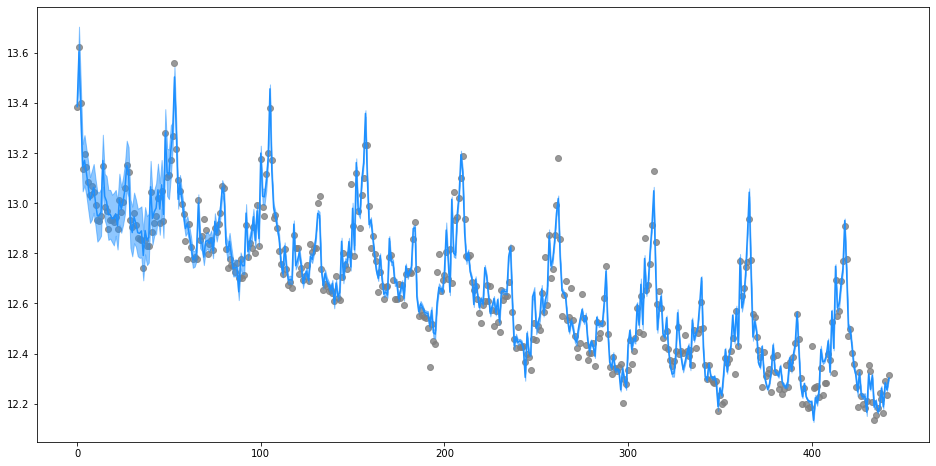

In [283]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
x = np.arange(len(response))
ax.scatter(x, response, color='grey', alpha=0.8)
ax.plot(x, yhat_med, color='dodgerblue')
ax.fill_between(x, yhat_lower, yhat_upper, color='dodgerblue', alpha=0.5)